In [1]:
import sys, os
# Load graph eval library
GRAPH_EVAL_PATH = os.path.abspath('ggme/src/')
sys.path.append(GRAPH_EVAL_PATH)
from correlation import compute_correlation
# Reset path
sys.path.pop()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from graph_utils import get_dist_grid_codes
from transfer_learning_experiment import get_performance_test_cases as tl_get_performance_test_cases
from out_of_distribution_experiment import get_performance_test_cases as ood_get_performance_test_cases

from IPython.display import display

# Load Experiment Results

In [386]:
"""
FOR MODELS WITH FIXED KNOWN VALUES
"""

DC_PF_FILE = 'dc_pf_data.csv'
dc_pf_df = pd.read_csv(DC_PF_FILE, index_col=0)
# print(dc_pf_df.describe(), '\n')

TL_FILE = 'tl_experiment_data.csv'
tl_performance_df = pd.read_csv(TL_FILE, index_col=0)
# print(tl_performance_df.describe(), '\n')

TL_MMD_FILE = 'tl_mmds_data.csv'
tl_mmd_df = pd.read_csv(TL_MMD_FILE, index_col=0)
# print(tl_mmd_df.describe(), '\n')

OOD_FILE = 'ood_experiment_data.csv'
ood_performance_df = pd.read_csv(OOD_FILE, index_col=0)
# print(ood_performance_df.describe(), '\n')

OOD_MMD_FILE = 'ood_mmds_data.csv'
ood_mmd_df = pd.read_csv(OOD_MMD_FILE, index_col=0)
# print(ood_mmd_df.describe(), '\n')

### Choose which NRMSE value we want to analyze

In [388]:
nrmse_to_use = 'nrmse_range'

dc_pf_df['nrmse_test'] = dc_pf_df[nrmse_to_use]
tl_performance_df['nrmse_test'] = tl_performance_df[nrmse_to_use]
ood_performance_df['nrmse_test'] = ood_performance_df[nrmse_to_use]

# Graph Similarity Analysis

In [425]:
tl_mmd_df.describe()

,mmd_degree,mmd_laplacian,mmd_cycle
count,45.000000,45.000000,45.000000
mean,0.496524,1.504970,0.163065
std,0.485316,0.308268,0.141096
min,0.004249,1.029652,0.000042
25%,0.135125,1.241497,0.038371
50%,0.290575,1.489830,0.179620
75%,0.660173,1.775929,0.265746
max,1.746394,1.998903,0.502904


In [426]:
ood_mmd_df.describe()

,mmd_degree,mmd_laplacian,mmd_cycle
count,10.000000,10.000000,10.000000
mean,0.788942,0.838901,0.517849
std,0.293471,0.224525,0.494091
min,0.468654,0.642798,0.128661
25%,0.553539,0.690105,0.129337
50%,0.745955,0.743402,0.264660
75%,0.907327,0.925555,0.908215
max,1.420892,1.334370,1.367956


## MMD Range

In [476]:
def show_mmd_range(experiment, mmd_df, descriptors=['mmd_degree', 'mmd_laplacian'], axes=None, show=True, title=None):
    if axes:
        assert(len(axes) == len(descriptors))
    else:
        fig, axes = plt.subplots(len(descriptors), sharex=True)
    for desc, ax in zip(descriptors, axes):
        print(experiment, desc)
        print('Total mmds:', len(mmd_df))
        print('Unique mmds:', len(mmd_df[desc].unique()))
        ax.scatter(range(len(mmd_df)), sorted(mmd_df[desc].values), label=desc)
        ax.legend()
        
    fig.supylabel('mmd')
    fig.supxlabel('id')
    fig.suptitle(f'{experiment}')
    if show:
        plt.show()

TL mmd_degree
Total mmds: 45
Unique mmds: 45
TL mmd_laplacian
Total mmds: 45
Unique mmds: 45


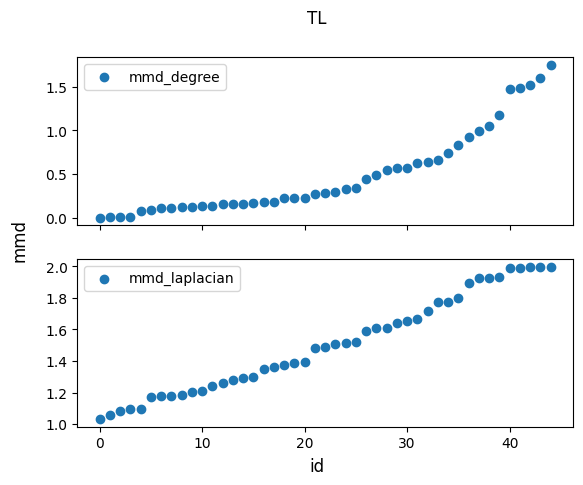

In [479]:
show_mmd_range('TL', tl_mmd_df, show=False)
plt.savefig('figures/fig_mmd_range_tl.pdf', format='pdf', dpi=1200)

OOD mmd_degree
Total mmds: 10
Unique mmds: 10
OOD mmd_laplacian
Total mmds: 10
Unique mmds: 10


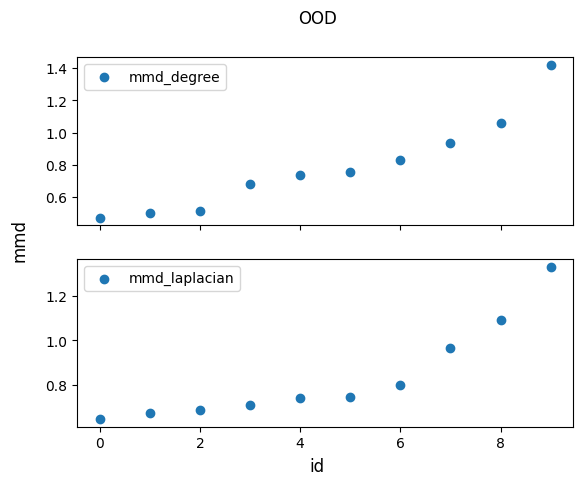

In [480]:
show_mmd_range('OOD', ood_mmd_df, show=False)
plt.savefig('figures/fig_mmd_range_ood.pdf', format='pdf', dpi=1200)

## MMD Between Reference Grids

In [496]:
def get_mmd(df, train_grid, test_grid, descriptor, already_reversed=False):
    mmd_arr = df[(df['training_grid'] == train_grid) &
                 (df['testing_grid'] == test_grid)][descriptor].values
    if (len(mmd_arr)) == 0:
        # MMD is symmetrical, so only one row per pair, so try other direction.
        if already_reversed:
            raise ValueError('We have already checked symmetry for mmd')
        else:
            return get_mmd(df, test_grid, train_grid, descriptor, already_reversed=True)
    return mmd_arr[0]

def plot_mmd_heatmap(mmd_df, descriptor, show=True):
    grids = get_dist_grid_codes(scenario=1)

    corr_mmd = np.ones((len(grids),len(grids)))*np.nan
    for i, train_grid in enumerate(grids):
        for j, test_grid in enumerate(grids):
            if train_grid != test_grid:
                mmd = get_mmd(mmd_df, train_grid, test_grid, descriptor)
                corr_mmd[i,j] = mmd

    vmin = mmd_df[descriptor].min()
    names = list(map(lambda x: x.split('--')[0][2:], grids))
    ax = sns.heatmap(corr_mmd, annot=False, xticklabels=names, yticklabels=names, cmap='Blues', linewidth=.5, vmin=vmin)
    ax.set_title('TL - ' + descriptor.lower())
    if show:
        plt.show()

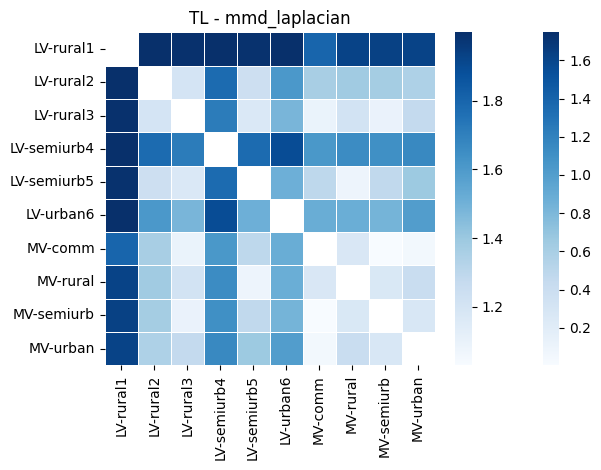

In [497]:
plot_mmd_heatmap(tl_mmd_df, 'mmd_degree', show=False)
plt.tight_layout()
plt.savefig('figures/fig_grids_mmd_degree.pdf', format='pdf', dpi=1200)
plot_mmd_heatmap(tl_mmd_df, 'mmd_laplacian', show=False)
plt.tight_layout()
plt.savefig('figures/fig_grids_mmd_laplacian.pdf', format='pdf', dpi=1200)

# Performance Analysis

#### Let's take a look at model performance. This can be used to help us confirm some of our theories about GNN-based PF model generalizability.

In [501]:
DEFAULT_VARIATIONS = {
    # (cycles, path_lengths, degree, dc_pf)
    'none': (False, False, False, False),
    'degree': (False, False, True, False),
    'cycles': (True, False, False, False),
    'paths': (False, True, False, False),
    'dc_pf': (False, False, False, True)
}

def get_colors(n, padding=4):
    return plt.cm.Paired(np.linspace(0, 1, n + padding*2))[padding:-padding]

def get_performance_variation(performance_df, cycles, path_lengths, degree, dc_pf):
    if dc_pf:
        df = dc_pf_df.copy(deep=True)
        # Only use the dc values where the same grids from performance_df are being tested.
        df = df[df['testing_grid'].isin(performance_df['testing_grid'].unique())]
        return df
    df = performance_df
    data_df = df[(df['cycles'] == cycles) & (df['path_lengths'] == path_lengths) & (df['degree'] == degree)]
    return data_df

def get_nrmse_data(performance_df, cycles, path_lengths, degree, dc_pf):
    return get_performance_variation(performance_df, cycles, path_lengths, degree, dc_pf)['nrmse_test']

def perform_stat(data, stat='mean'):
    if stat=='mean':
        return data.mean()
    elif stat=='min':
        return data.min()
    elif stat=='max':
        return data.max()
    else:
        assert False, 'need to provide a valid stat'

def compare_avg_performance(experiment, performance_df, stat='mean', variations=DEFAULT_VARIATIONS):
    means = []
    for name, v in variations.items():
        c, p, d, dc = v
        data = get_nrmse_data(performance_df,c,p,d,dc)
        means.append((name, perform_stat(data, stat=stat)))

    color = get_colors(len(variations))
    x, height = zip(*means)
    plt.bar(x, height, color=color)
    # plt.xlabel('model')
    plt.ylabel('nrmse')
    plt.title(f'{experiment} - NRMSE Model Comparison ({stat})')
    plt.show()

def show_performance_dist(experiment, performance_df, variations=DEFAULT_VARIATIONS, show=True):
    x = []
    y = []
    for name, v in variations.items():
        c, p, d, dc = v
        data = get_nrmse_data(performance_df,c,p,d,dc)
        x.extend(np.repeat(name, len(data)))
        y.extend(data.values)
    color = get_colors(len(variations))
    sns.boxplot(x=x, y=y, showfliers=False, palette=color.tolist())
    # plt.xlabel('model')
    plt.ylabel('nrmse')
    plt.title(f'{experiment} - NRMSE Model Distritbuion')
    if show:
        plt.show()

In [16]:
dc_pf_df.describe()

,nrmse_arma,nrmse_range,nrmse_mean,nrmse_std,nrmse_test
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.460864,0.004563,-0.005014,0.045765,0.004563
std,0.172562,0.002417,0.002355,0.028926,0.002417
min,0.274785,0.001500,-0.009131,0.006144,0.001500
25%,0.376728,0.003343,-0.006362,0.027064,0.003343
50%,0.419031,0.003964,-0.004777,0.040995,0.003964
75%,0.524091,0.006062,-0.004003,0.063941,0.006062
max,0.871458,0.008934,-0.001660,0.102306,0.008934


In [ ]:
tl_performance_df.describe()

,nrmse_arma,nrmse_range,nrmse_mean,nrmse_std,best_val_loss,train_time,total_epochs,nrmse_test
count,540.000000,540.000000,540.000000,540.000000,540.0,540.0,540.0,540.000000
mean,56.834536,0.049266,-0.078230,0.411058,0.0,0.0,0.0,0.049266
std,753.541132,0.053091,0.268842,0.340264,0.0,0.0,0.0,0.053091
min,0.436007,0.001838,-4.322066,0.007766,0.0,0.0,0.0,0.001838
25%,1.339757,0.008514,-0.078601,0.083778,0.0,0.0,0.0,0.008514
50%,2.813886,0.037555,-0.043679,0.350052,0.0,0.0,0.0,0.037555
75%,7.044145,0.069923,-0.009754,0.675156,0.0,0.0,0.0,0.069923
max,14810.972734,0.391748,-0.001905,1.800844,0.0,0.0,0.0,0.391748


In [ ]:
ood_performance_df.describe()

,nrmse_arma,nrmse_range,nrmse_mean,nrmse_std,best_val_loss,train_time,total_epochs,nrmse_test
count,60.000000,60.000000,60.000000,60.000000,60.0,60.0,60.0,60.000000
mean,2.198320,0.019126,-0.021823,0.122263,0.0,0.0,0.0,0.019126
std,4.723374,0.039140,0.044227,0.152174,0.0,0.0,0.0,0.039140
min,0.280399,0.001938,-0.221327,0.013873,0.0,0.0,0.0,0.001938
25%,0.597253,0.004458,-0.012193,0.045306,0.0,0.0,0.0,0.004458
50%,0.856744,0.006706,-0.007624,0.068608,0.0,0.0,0.0,0.006706
75%,1.624849,0.011694,-0.004767,0.124747,0.0,0.0,0.0,0.011694
max,33.316961,0.195346,-0.001998,0.751363,0.0,0.0,0.0,0.195346


## TL

##### How well can learning on just one single grid help us perform on another never-before-seen grid?

### All GNN Models - Mean and Distribution

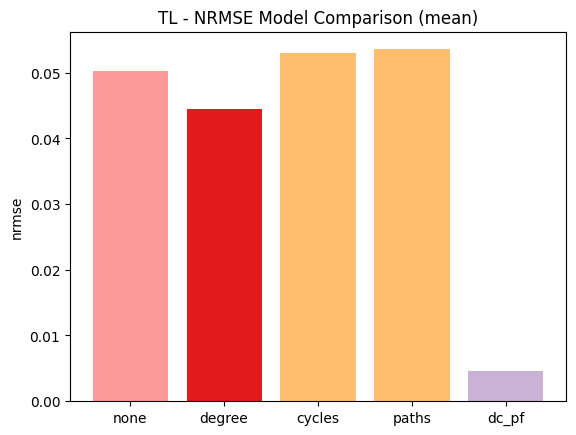

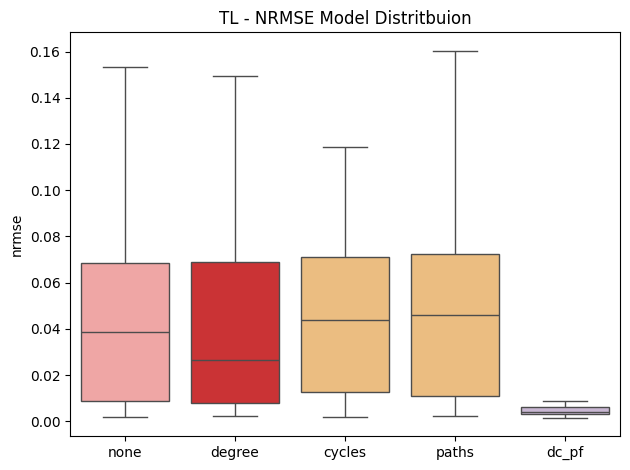

In [502]:
custom_variations = {
    'none': (False, False, False, False),
    'degree': (False, False, True, False),
    'cycles': (True, False, False, False),
    'paths': (False, True, False, False),
    'dc_pf': (False, False, False, True),
}

compare_avg_performance('TL', tl_performance_df, stat='mean', variations=custom_variations)
show_performance_dist('TL', tl_performance_df, variations=custom_variations, show=False)
plt.tight_layout()
plt.savefig('figures/fig_tl_models_nrmse.pdf', format='pdf', dpi=1200)

##### Results: They all seem to perform similarly, so added features seem to help only marginally. Since the degree model seems to have a slight edge, let us compare it to the typical DC PF model nrmse.

### Best model vs DC PF - Mean and Distribution

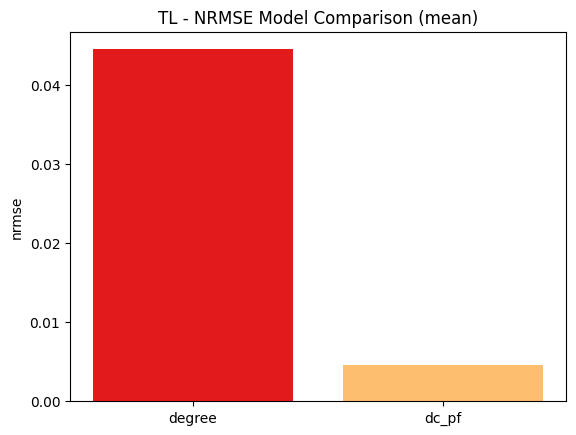

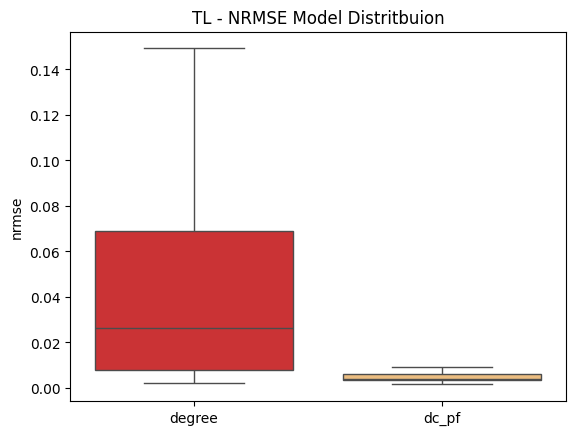

In [ ]:
custom_variations = {
    'degree': (False, False, True, False),
    'dc_pf': (False, False, False, True),
}

compare_avg_performance('TL', tl_performance_df, stat='mean', variations=custom_variations)
show_performance_dist('TL', tl_performance_df, variations=custom_variations)

##### Results: The DC PF model is far better. But we notice there is a big spread in the performance of the degree model... It seems there is not enough to learn in just one grid that can be generalized as well as DC PF using these few added features.
##### That is unfortunate. However, our degree model has quite a wide distribution. Let us see if there are actually cases in which it performs better than DC PF.

In [21]:
df = tl_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]

total = 0
gnn_better = 0
mmds_degree = []
mmds_laplacian = []
for _, row in df.iterrows():
    if row['nrmse_test'] < dc_pf_df[dc_pf_df['testing_grid'] == row['testing_grid']]['nrmse_test'].min(): # only 1 value anyways
        gnn_better += 1
    total += 1

print(f'Degree GNN model outperforms DC PF in {gnn_better}/{total} cases of TL.')

Degree GNN model outperforms DC PF in 12/90 cases of TL.


##### Results: There are indeed some cases in which our degree model performs better than the DC PF model, so there is still further work in understanding why.

## OOD

##### How well can learning on several grids help us perform on another never-before-seen grid?

### All GNN Models - Mean and Distribution

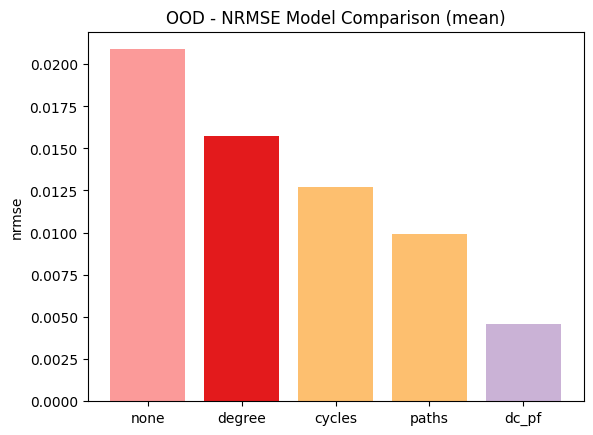

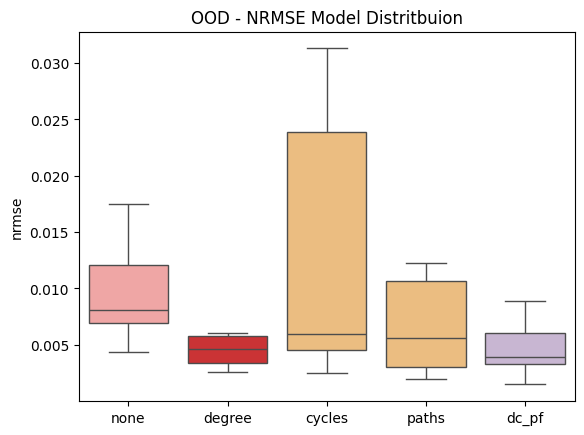

In [498]:
custom_variations = {
    'none': (False, False, False, False),
    'degree': (False, False, True, False),
    'cycles': (True, False, False, False),
    'paths': (False, True, False, False),
    'dc_pf': (False, False, False, True),
}

compare_avg_performance('OOD', ood_performance_df, stat='mean', variations=custom_variations)
show_performance_dist('OOD', ood_performance_df, variations=custom_variations, show=False)
plt.tight_layout()
plt.savefig('figures/fig_ood_models_nrmse.pdf', format='pdf', dpi=1200)

##### Results: Here we really see the added effects of graphical features. Since the model has more variations in graphs to learn from, it can also learn how to properly take advantage of this extra information. Paths as an added feature seams to perform better on average from our test cases, but degree as an added feature is not only better than the model with no added features, but also shows a much more stable distribution in general. This makes the degree model a viable candidate for generalizability.

##### Since the "degree" model seems to be better and more stable model that the model with no added features, this should mean it generalizes better. We verify this later by checking their MMD / NRMSE Correlations.

### Best models vs DC PF - Mean and Distribution

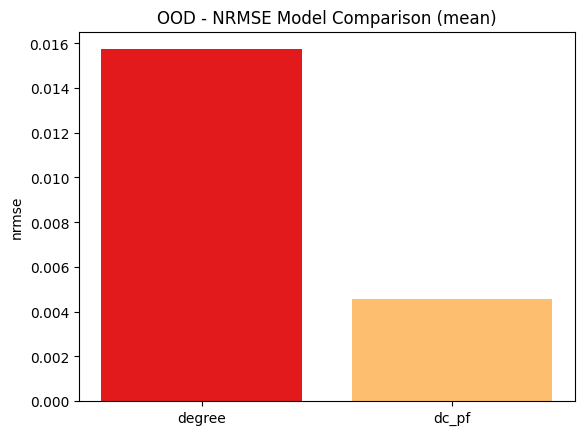

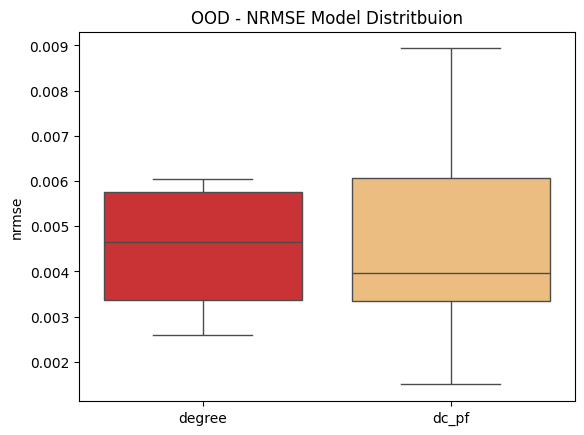

In [381]:
custom_variations = {
    'degree': (False, False, True, False),
    # 'paths': (False, True, False, False),
    'dc_pf': (False, False, False, True),
}

compare_avg_performance('OOD', ood_performance_df, stat='mean', variations=custom_variations)
show_performance_dist('OOD', ood_performance_df, variations=custom_variations)

##### Result: The data indicates a strong linear correlation (pearson) but a very weak monotonic correlation (spearman). This does not look very convincing that the OOD model has a correlation of mmd and model performance.
##### As we increase in MMD, the nrmse does not usually increase much, if anything. This indicates that the OOD model is more capable of capturing model "difference", which is a sign of robustness.
##### We cannot segment this model further because there are multiple training grids used to predict the one target, and this information would not tell us much.

# Similarity / Performance Combination -> Generalization Score

#### Can we use the MMD / NRMSE curve as a "generalizability" curve for GNN-based models?

In [489]:
def get_mmd_nrmse_correlation_dc(dc_pf_df):
    nrmses = dc_pf_df['nrmse_test'].values
    return np.repeat(0, len(nrmses)), nrmses

def get_mmd_nrmse_correlation(experiment, performance_df, mmd_df, descriptor, show=False):
    def get_sub_df(experiment, df, test_case):
        if experiment.lower() == 'tl':
            return df[(df['training_grid'] == test_case[0]) & (df['testing_grid'] == test_case[1])]
        elif experiment.lower() == 'ood':
            return df[df['testing_grid'] == test_case[1]]
        else:
            assert False, 'need a valid experiment'

    experiment_full = experiment
    experiment = experiment.split(' ')[0]
    if experiment.lower() == 'tl':
        test_cases = tl_get_performance_test_cases(get_dist_grid_codes(scenario=1))
    elif experiment.lower() == 'ood':
        test_cases = ood_get_performance_test_cases(get_dist_grid_codes(scenario=1))
    else:
        return None
    
    mmds = []
    nrmses = []
    for case in test_cases:
        test_nrmses = get_sub_df(experiment, performance_df, case)['nrmse_test'].values.tolist()
        if len(test_nrmses) == 0:
            continue
        
        nrmses.extend(
            test_nrmses
        )
        mmd_arr = get_sub_df(experiment, mmd_df, case)[descriptor].values
        if len(mmd_arr) == 0:
            # MMD is symmetrical, so only one entry per pair.
            case = list(reversed(case))
            mmd_arr = get_sub_df(experiment, mmd_df, case)[descriptor].values
        mmds.extend(
            [mmd_arr[0]]*len(test_nrmses)
        )
    if show:
        plt.scatter(mmds, nrmses, label=experiment_full)
        plt.xlabel('mmd')
        plt.ylabel('nrmse')
        plt.legend()
        plt.title(f'{experiment} - {descriptor}')
    return np.array(mmds), np.array(nrmses)

def plot_corr_line(mmds, nrmses, confidence):
    poly_coefficients = np.polyfit(mmds, nrmses, 1)

    if confidence > 0.5:
        alpha = 1.0
    elif confidence > 0.25:
        alpha = 0.4
    elif confidence > 0:
        alpha = 0.1
    else:
        return np.zeros(2)

    plt.plot(np.unique(mmds), np.poly1d(poly_coefficients)(np.unique(mmds)), '--r', alpha=alpha)
    return poly_coefficients

def get_percentile_bounds(nrmses, bounds=2):
    p_min = np.percentile(nrmses, bounds)
    p_max = np.percentile(nrmses, 100-bounds)
    return p_min, p_max

def get_generalization_score(mmds, nrmses, alpha=1.0):
    # Calculate the generalization score and return its components.
    eps = 1e-8
    p_min, p_max = get_percentile_bounds(nrmses)
    p_where = (nrmses <= p_max) & (nrmses >= p_min)
    min_mmd_percentile = mmds.min(where=p_where, initial=mmds.max())
    max_mmd_percentile = mmds.max(where=p_where, initial=mmds.min())
    mmd_range_percentile = max_mmd_percentile - min_mmd_percentile
    mean_nrmse_percentile = nrmses.mean(where=p_where)
    std_rmse_percentile = nrmses.std(where=p_where)

    score = mean_nrmse_percentile + alpha*std_rmse_percentile*(np.log(mmd_range_percentile + 1) / (mmd_range_percentile + eps))

    return mean_nrmse_percentile, std_rmse_percentile, mmd_range_percentile, score

def plot_percentile(mmds, nrmses):
    p_min, p_max = get_percentile_bounds(nrmses)

    # Fill area between bounds
    y_min, _ = plt.ylim()
    x_min, x_max = plt.xlim()
    plt.fill_between([x_min] + sorted(mmds)[1:-1] + [x_max], p_min, p_max, alpha=0.1, color='gray')
    plt.ylim(bottom=y_min)
    plt.xlim(x_min, x_max)
    return

def show_correlation(experiment, performance_df, mmd_df, descriptors=None, show=True, plot_correlations=True):
    if not descriptors:
        descriptors = list(filter(lambda col: 'mmd' in col, mmd_df.columns))
    total_points = 0
    for desc in descriptors:
        mmds, nrmses = get_mmd_nrmse_correlation(experiment,
                                                 performance_df,
                                                 mmd_df,
                                                 desc,
                                                 show=True)
        
        if len(mmds) == 0:
            print('No data')
            continue
        confidence = 0
        pearson = compute_correlation(mmds, nrmses, correlation_type='pearson')
        print(f'pearson correlation:', pearson)
        spearman = compute_correlation(mmds, nrmses, correlation_type='spearman')
        print(f'spearman correlation:', spearman)
        confidence = 0 if spearman < 0.095 else np.mean([pearson, spearman])
        if plot_correlations:
            coeffs = plot_corr_line(mmds, nrmses, confidence)
            print('[slope y-intercept]:', coeffs)
            plot_percentile(mmds, nrmses)
            _, _, _, score = get_generalization_score(mmds, nrmses)
            print(f'generalization score: {score}')
            # print(f'\t score {(max_nrmse - min_nrmse) / cv_rmse}')
        if show:
            plt.show()
        total_points += len(mmds)
    return total_points

def get_segments_tl(segments_list, cases_df):
    segments = []
    for train_seg, test_seg in segments_list:
        train_parts = train_seg.split('!')
        test_parts = test_seg.split('!')
        seg_df = cases_df.query(
            f" ({'not' if len(train_parts) > 1 else ''} training_grid.str.contains('{train_parts[-1]}')) and ({'not' if len(test_parts) > 1 else ''} testing_grid.str.contains('{test_parts[-1]}'))")
        segments.append((train_seg, test_seg, seg_df))
    return segments

def get_segments_ood(segments_list, cases_df):
    segments = []
    for test_seg in segments_list:
        test_parts = test_seg.split('!')
        seg_df = cases_df.query(
            f"({'not' if len(test_parts) > 1 else ''} testing_grid.str.contains('{test_parts[-1]}'))")
        segments.append((test_seg, seg_df))
    return segments

## TL

### Check the TL Correlation with the 'none' model, to see if there is a relationship between model performance and grid similarity.

pearson correlation: 0.5103219567108693
spearman correlation: 0.3158505765831034
[slope y-intercept]: [0.05762299 0.02158459]
generalization score: 0.06282715503711406


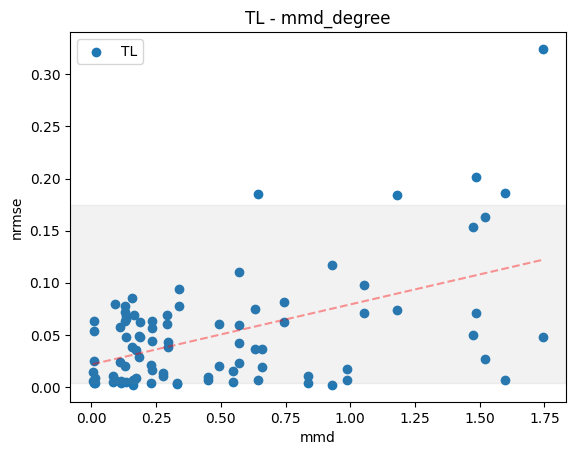

pearson correlation: 0.35877078551598074
spearman correlation: 0.20868992845450177
[slope y-intercept]: [ 0.06377713 -0.04578689]
generalization score: 0.06698738075423202


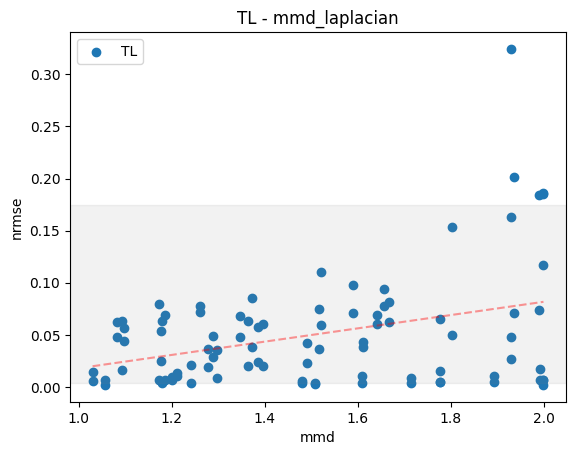

In [410]:
df = tl_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]

_ = show_correlation('TL', df, tl_mmd_df, descriptors=['mmd_degree', 'mmd_laplacian'])

#####  Result: The data indicates a moderate linear correlation (pearson) but a weak monotonic correlation (spearman).
##### To further investigate this, let's see if we can split this up into segments to see which types of experiments provide a stronger correlation.

### Segment the TL correlation results based on different splits, and check the same correlation.

In [378]:
get_dist_grid_codes(scenario=1)

['1-LV-rural1--1-no_sw',
 '1-LV-rural2--1-no_sw',
 '1-LV-rural3--1-no_sw',
 '1-LV-semiurb4--1-no_sw',
 '1-LV-semiurb5--1-no_sw',
 '1-LV-urban6--1-no_sw',
 '1-MV-comm--1-no_sw',
 '1-MV-rural--1-no_sw',
 '1-MV-semiurb--1-no_sw',
 '1-MV-urban--1-no_sw']

##### First, we split up into LV and MV grid segments (as training data)


LV as training
pearson correlation: 0.3388781871314155
spearman correlation: 0.2771899836905559
[slope y-intercept]: [0.0318176  0.02235875]
generalization score: 0.03563836155962855


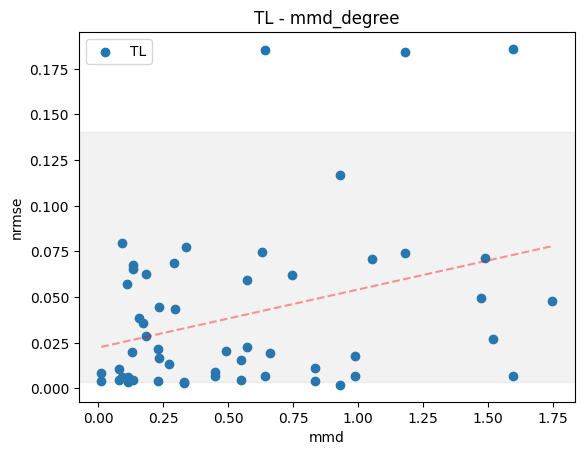

pearson correlation: 0.2800225894994485
spearman correlation: 0.10004766398954863
[slope y-intercept]: [ 0.04225986 -0.0273908 ]
generalization score: 0.06732245777208365


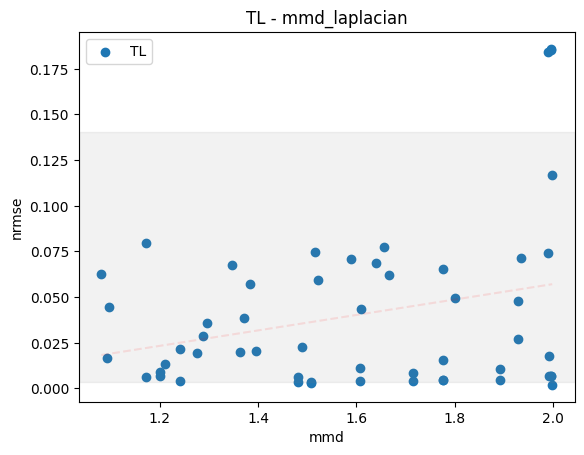


MV as training
pearson correlation: 0.8324774104004783
spearman correlation: 0.526458131198186
[slope y-intercept]: [0.1112303  0.02013864]
generalization score: 0.06266367079236339


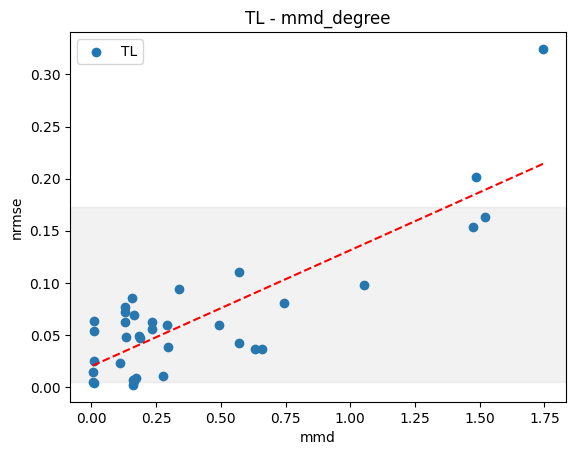

pearson correlation: 0.7687882601605979
spearman correlation: 0.6634479701795677
[slope y-intercept]: [ 0.18373553 -0.18601797]
generalization score: 0.10572532689155295


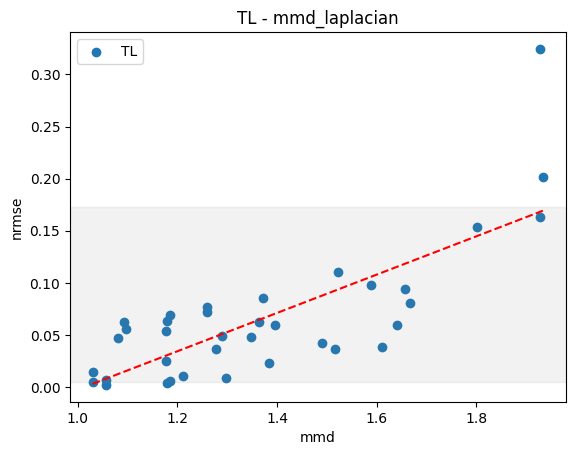

In [ ]:
grid_segments = [
    ('LV', ''),
    ('MV', '')
]

df = tl_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]
segments_tl = get_segments_tl(grid_segments, df)

for train_seg, test_seg, segmented_df in segments_tl:
    print(f'\n{train_seg} as training')
    show_correlation('TL', segmented_df, tl_mmd_df, descriptors=['mmd_degree', 'mmd_laplacian'])


##### Result: Although there are only weak correlations when the training set is an LV grid, there seems to be a strong linear correlation (pearson) and a moderate-strong spearman correlation in the MV grid segment.

##### Next, we segment the data by grid type (i.e. rural, semiurb, urban, comm) and check for correlations


rural as training
pearson correlation: 0.35794923896639524
spearman correlation: 0.14690357732871856
[slope y-intercept]: [0.02767152 0.02577086]
generalization score: 0.03810504334819805


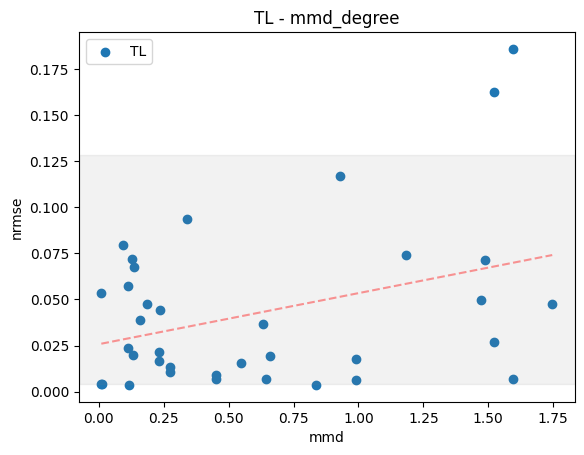

pearson correlation: 0.2975853904685115
spearman correlation: 0.11909361001670873
[slope y-intercept]: [ 0.03804953 -0.01594442]
generalization score: 0.07213074953833816


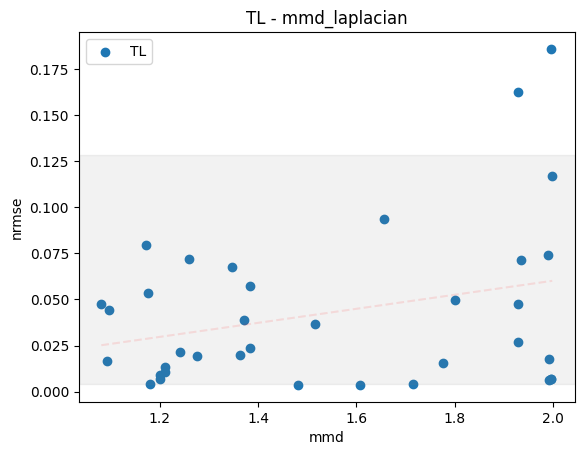


semiurb as training
pearson correlation: 0.6795813467632146
spearman correlation: 0.2595816427493928
[slope y-intercept]: [0.09410857 0.01261982]
generalization score: 0.08486394627707021


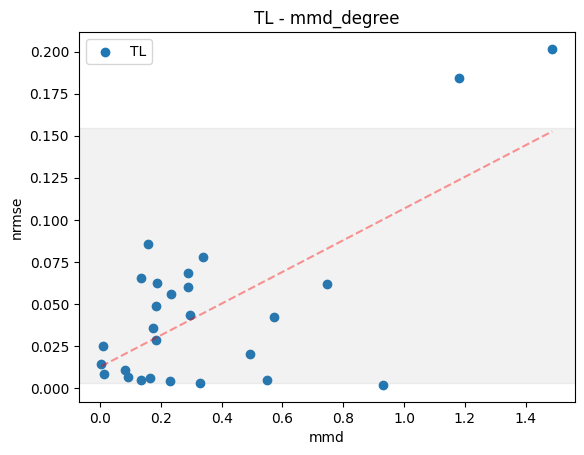

pearson correlation: 0.35116780688817256
spearman correlation: 0.09589251273330514
[slope y-intercept]: [ 0.05893107 -0.0431377 ]
generalization score: 0.0727542540189715


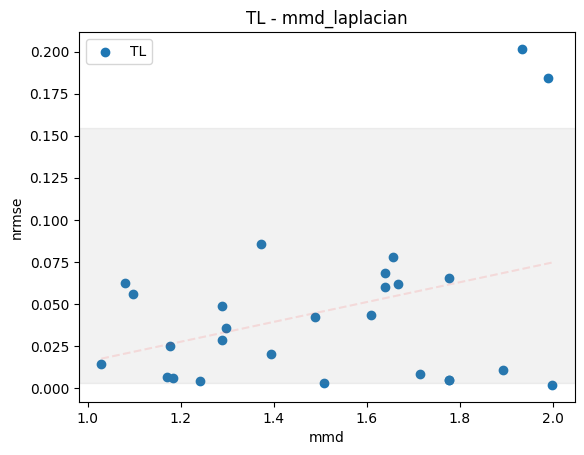


urban as training
pearson correlation: 0.7228747311690055
spearman correlation: 0.5792463342909246
[slope y-intercept]: [ 0.12992092 -0.00416002]
generalization score: 0.10431121296495556


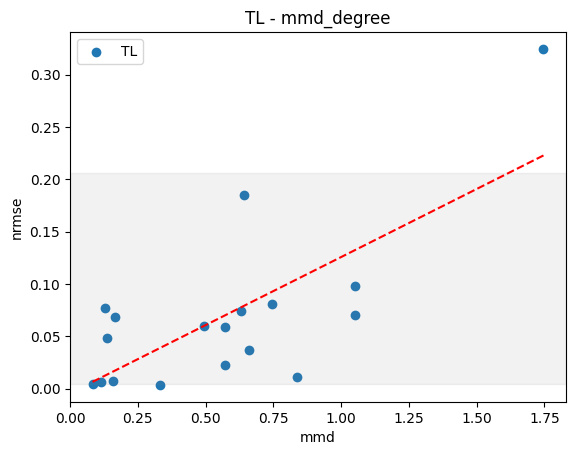

pearson correlation: 0.5353355956705682
spearman correlation: 0.34589576111846665
[slope y-intercept]: [ 0.16576771 -0.18263255]
generalization score: 0.10750634006756933


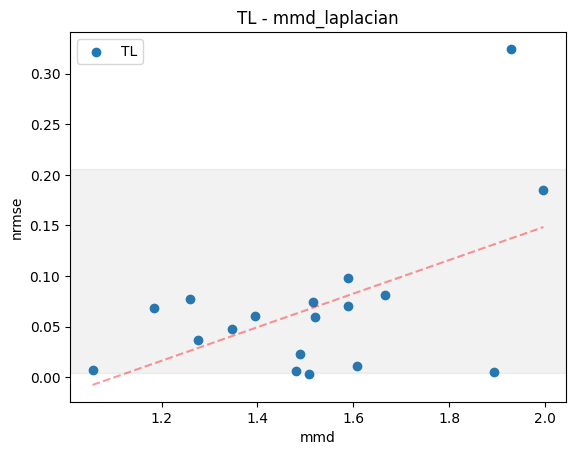


comm as training
pearson correlation: 0.8259039525215057
spearman correlation: 0.5166666666666667
[slope y-intercept]: [0.09140892 0.02538705]
generalization score: 0.14825017541607768


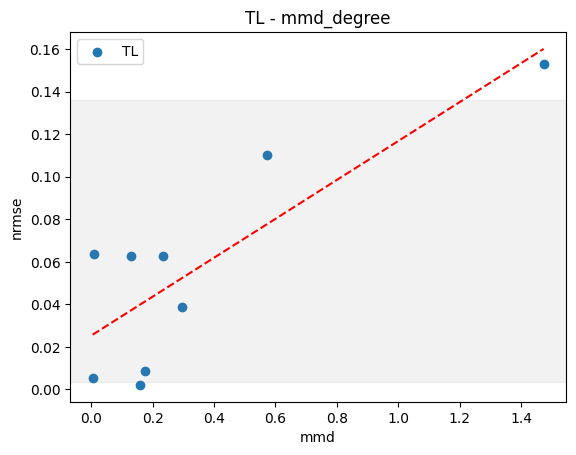

pearson correlation: 0.7338179529093181
spearman correlation: 0.7
[slope y-intercept]: [ 0.13771408 -0.12650479]
generalization score: 0.1448069522803688


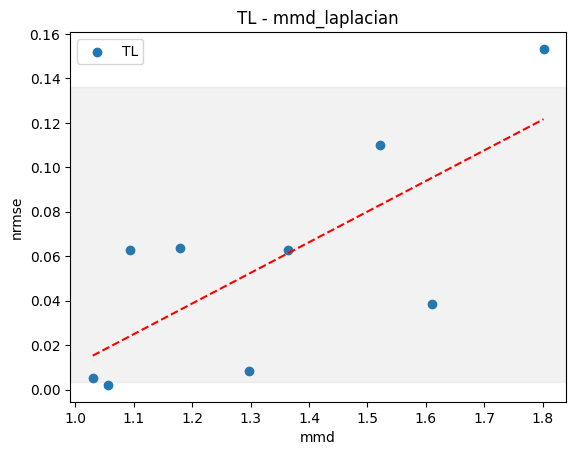

In [380]:
grid_segments = [
    ('rural', ''),
    ('semiurb', ''),
    ('urban', ''),
    ('comm', ''),
]

df = tl_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]
segments_tl = get_segments_tl(grid_segments, df)

for train_seg, test_seg, segmented_df in segments_tl:
    print(f'\n{train_seg} as training')
    _ = show_correlation('TL', segmented_df, tl_mmd_df, descriptors=['mmd_degree', 'mmd_laplacian'])


##### Result: Correlations increase as we increase the "urbanness" of the grid. We go from weak all the way to strongly correlated.

### Results Summary TL

In [490]:
DEFAULT_VARIATIONS = {
    # (cycles, path_lengths, degree, dc_pf)
    'none': (False, False, False, False),
    'degree': (False, False, True, False),
    'cycles': (True, False, False, False),
    'paths': (False, True, False, False),
    'dc_pf': (False, False, False, True)
}

grid_segments = [
    ('', ''), # All
    ('LV', ''),
    ('MV', ''),
    ('rural', ''),
    ('semiurb', ''),
    ('urban', ''),
    ('comm', ''),
]

def get_generalization_results_summary(experiment, performance_df, mmd_df, descriptor, variations=DEFAULT_VARIATIONS):
    columns = ['name', 'rmse_mean', 'rmse_std', 'mmd_range', 'score']
    results = []
    for name, v in variations.items():
        c, p, d, dc = v
        variation_df = get_performance_variation(performance_df,c,p,d,dc)
        if dc:
            mmds, nrmses = get_mmd_nrmse_correlation_dc(variation_df)
        else:
            mmds, nrmses = get_mmd_nrmse_correlation(experiment,
                                                 variation_df,
                                                 mmd_df,
                                                 descriptor)
        rmse_mean, rmse_std, mmd_range, score = get_generalization_score(mmds, nrmses)
        results.append((name, rmse_mean, rmse_std, mmd_range, score))
    return pd.DataFrame(results, columns=columns)

In [491]:
grid_segments = [
    ('', ''), # All
    ('LV', ''),
    ('MV', ''),
    ('rural', ''),
    ('semiurb', ''),
    ('urban', ''),
    ('comm', ''),
]
segments_tl = get_segments_tl(grid_segments, tl_performance_df)

results = []

for train_seg, test_seg, segmented_df in segments_tl:
    df = get_generalization_results_summary('TL', segmented_df, tl_mmd_df, 'mmd_degree', variations=DEFAULT_VARIATIONS)
    name = train_seg if train_seg else 'all'
    df['segment_tl'] = name
    results.append(df)
    print(name)
    display(df)

tl_generalization_results_df = pd.concat(results, ignore_index=True)

all


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.046367,0.043165,1.742145,0.071361,all
1,degree,0.040988,0.038533,1.742145,0.063299,all
2,cycles,0.046991,0.040380,1.742145,0.070372,all
3,paths,0.049699,0.042908,1.742145,0.074543,all
4,dc_pf,0.004400,0.001728,0.000000,0.004400,all


LV


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.035744,0.035292,1.733575,0.056216,LV
1,degree,0.033161,0.027292,1.733575,0.048992,LV
2,cycles,0.042233,0.027107,1.733575,0.057957,LV
3,paths,0.042599,0.036799,1.733575,0.063945,LV
4,dc_pf,0.004400,0.001728,0.000000,0.004400,LV


MV


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.059646,0.045319,1.516249,0.087227,MV
1,degree,0.049080,0.042035,1.742145,0.073419,MV
2,cycles,0.056746,0.065464,1.516249,0.096587,MV
3,paths,0.057456,0.043634,1.742145,0.082721,MV
4,dc_pf,0.004400,0.001728,0.000000,0.004400,MV


rural


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.039645,0.036018,1.737155,0.060522,rural
1,degree,0.038000,0.037494,1.737155,0.059733,rural
2,cycles,0.050826,0.027945,1.737155,0.067024,rural
3,paths,0.040475,0.029926,1.737155,0.057821,rural
4,dc_pf,0.004400,0.001728,0.000000,0.004400,rural


semiurb


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.041201,0.039100,1.176936,0.067045,semiurb
1,degree,0.037663,0.030914,1.477847,0.056644,semiurb
2,cycles,0.039126,0.026131,1.482837,0.055152,semiurb
3,paths,0.051542,0.054094,1.176936,0.087297,semiurb
4,dc_pf,0.004400,0.001728,0.000000,0.004400,semiurb


urban


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.056944,0.044227,0.969902,0.087860,urban
1,degree,0.047423,0.038235,1.632420,0.070094,urban
2,cycles,0.034120,0.034016,0.938584,0.058110,urban
3,paths,0.071175,0.048558,1.663738,0.099769,urban
4,dc_pf,0.004400,0.001728,0.000000,0.004400,urban


comm


,name,rmse_mean,rmse_std,mmd_range,score,segment_tl
0,none,0.050294,0.033757,0.566948,0.077035,comm
1,degree,0.035605,0.036077,0.566948,0.064185,comm
2,cycles,0.048079,0.031596,0.566948,0.073109,comm
3,paths,0.037458,0.023401,1.469634,0.051854,comm
4,dc_pf,0.004575,0.001780,0.000000,0.004575,comm


In [392]:
tl_performance_df.head()

,training_grid,testing_grid,cycles,path_lengths,degree,nrmse_arma,nrmse_range,nrmse_mean,nrmse_std,best_val_loss,train_time,total_epochs,nrmse_test
0,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,False,False,False,1.839790,0.006756,-0.007038,0.068298,0.0,0.0,0,0.006756
1,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,True,True,False,9.477486,0.077103,-0.080903,0.719275,0.0,0.0,0,0.077103
2,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,True,False,False,11.003801,0.073857,-0.077519,0.690010,0.0,0.0,0,0.073857
3,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,False,True,False,12.290415,0.078820,-0.084279,0.771436,0.0,0.0,0,0.078820
4,1-LV-rural1--1-no_sw,1-LV-rural3--1-no_sw,False,False,False,1.013870,0.006598,-0.006756,0.075554,0.0,0.0,0,0.006598


### OOD

#### Check the OOD Correlation with the 'none' model, to see if there is a relationship between model performance and grid similarity.

pearson correlation: 0.7293401491817414
spearman correlation: 0.01818181818181818
[slope y-intercept]: [0. 0.]
p_max 0.10433948880806569
p_min 0.004445172771656237
90-percentile mmd:
	 min 0.4686536672781057
	 max 1.0571453490956937
90-percentile nrmse:
	 mean 0.009375582831756487
	 std 0.003786751843938413
generalization score: 0.02236622004814091


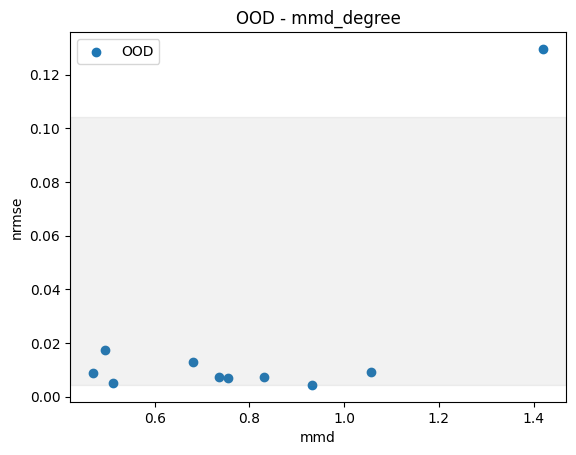

In [ ]:
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]

_ = show_correlation('OOD', df, ood_mmd_df, descriptors=['mmd_degree'])#, 'mmd_laplacian'])

pearson correlation: 0.7524620068600928
spearman correlation: 0.2606060606060606
[slope y-intercept]: [ 0.0897078  -0.05503555]
p_max 0.0914492284627631
p_min 0.0026082193406763974
90-percentile mmd:
	 min 0.4956673645363182
	 max 1.0571453490956937
90-percentile nrmse:
	 mean 0.004957132449295938
	 std 0.00210662532081691
generalization score: 0.0125806493550227


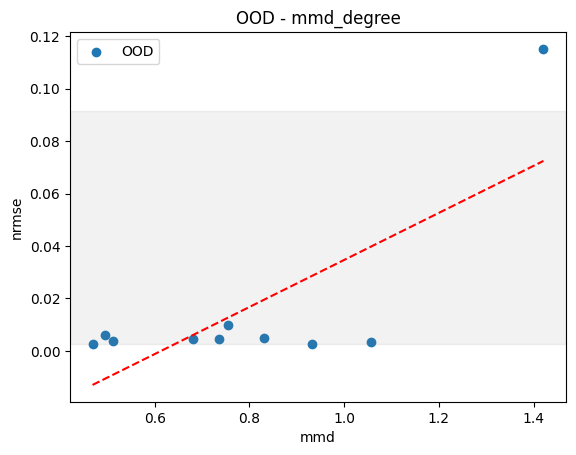

In [374]:
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == True)]

_ = show_correlation('OOD', df, ood_mmd_df, descriptors=['mmd_degree'])#, 'mmd_laplacian'])

### Best model vs 'None' Model - MMD Correlation


"None" model
pearson correlation: 0.7293401491817414
spearman correlation: 0.01818181818181818

"Degree" model
pearson correlation: 0.7524620068600928
spearman correlation: 0.2606060606060606


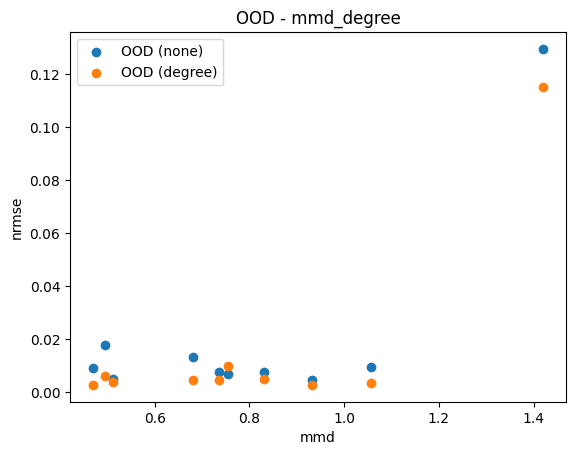


"None" model
pearson correlation: 0.7574868760405442
spearman correlation: 0.09090909090909088

"Degree" model
pearson correlation: 0.7986138712026098
spearman correlation: 0.5878787878787878


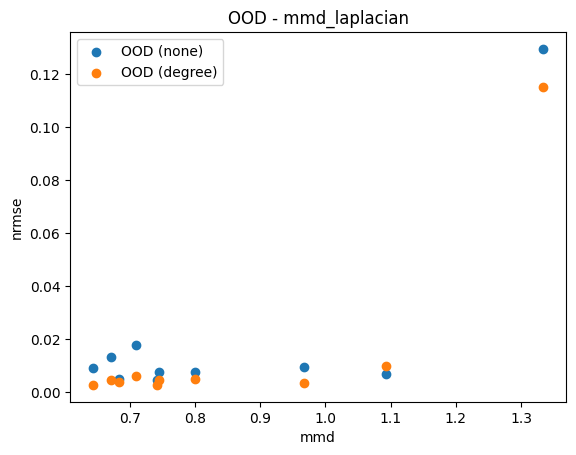

In [ ]:
# MMD DEGREE

# Plot 'none' model
print('\n"None" model')
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]

_ = show_correlation('OOD (none)', df, ood_mmd_df, descriptors=['mmd_degree'], show=False)#, 'mmd_laplacian'])

# Plot 'degree' model
print('\n"Degree" model')
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == True)]

_ = show_correlation('OOD (degree)', df, ood_mmd_df, descriptors=['mmd_degree'], show=False)#, 'mmd_laplacian'])

plt.show()

# MMD LAPLACIAN

# Plot 'none' model
print('\n"None" model')
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == False)]

_ = show_correlation('OOD (none)', df, ood_mmd_df, descriptors=['mmd_laplacian'], show=False)#, 'mmd_laplacian'])

# Plot 'degree' model
print('\n"Degree" model')
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == True)]

_ = show_correlation('OOD (degree)', df, ood_mmd_df, descriptors=['mmd_laplacian'], show=False)#, 'mmd_laplacian'])

plt.show()

##### Result: Both models follow the same trend of increased nrmse as mmd increases. However, the degree model consistently performs better than the model with no added features, showing that it is indeed more capable of generalization.
##### Let us now compare the degree model to the DC PF performance.

##### Results: Although it performs worse on average, it seems as the model with "degree" as a feature is quite comparable to DC PF when you look at stability and distribution. This suggests that the degree model in general can keep up with DC PF in solving unseen grids.
##### Let us see in how many cases the degree model outperforms dc_pf.

In [25]:
df = ood_performance_df
df = df[(df['cycles'] == False) &
        (df['path_lengths'] == False) &
        (df['degree'] == True)]

total = 0
gnn_better = 0
mmds_degree = []
mmds_laplacian = []
for _, row in df.iterrows():
    if row['nrmse_test'] < dc_pf_df[dc_pf_df['testing_grid'] == row['testing_grid']]['nrmse_test'].min(): # only 1 value anyways
        gnn_better += 1
    total += 1

print(f'Degree GNN model outperforms DC PF in {gnn_better}/{total} cases of OOD.')

Degree GNN model outperforms DC PF in 6/10 cases of OOD.


In [492]:
grid_segments = [
    (''), # All
]
segments_ood = get_segments_ood(grid_segments, ood_performance_df)

results = []

for test_seg, segmented_df in segments_ood:
    df = get_generalization_results_summary('OOD', segmented_df, ood_mmd_df, 'mmd_degree', variations=DEFAULT_VARIATIONS)
    name = test_seg if test_seg else 'all'
    df['segment_ood'] = name
    results.append(df)
    print(name)
    display(df)

ood_generalization_results_df = pd.concat(results, ignore_index=True)

all


,name,rmse_mean,rmse_std,mmd_range,score,segment_ood
0,none,0.009376,0.003787,0.588492,0.012353,all
1,degree,0.004957,0.002107,0.561478,0.006629,all
2,cycles,0.011651,0.009628,0.561478,0.019293,all
3,paths,0.006606,0.003586,0.464152,0.009553,all
4,dc_pf,0.004400,0.001728,0.000000,0.004400,all


In [433]:
grid_segments = [
    (''), # All
]
segments_ood = get_segments_ood(grid_segments, ood_performance_df)

results = []

for test_seg, segmented_df in segments_ood:
    df = get_generalization_results_summary('OOD', segmented_df, ood_mmd_df, 'mmd_degree', variations=DEFAULT_VARIATIONS)
    name = test_seg if test_seg else 'all'
    df['segment_ood'] = name
    results.append(df)
    print(name)
    display(df)

ood_generalization_results_df = pd.concat(results, ignore_index=True)

all


,name,rmse_mean,rmse_std,mmd_range,score,segment_ood
0,none,0.009376,0.003787,0.588492,0.012353,all
1,degree,0.004957,0.002107,0.561478,0.006629,all
2,cycles,0.011651,0.009628,0.561478,0.019293,all
3,paths,0.006606,0.003586,0.464152,0.009553,all
4,dc_pf,0.004400,0.001728,0.000000,0.004400,all


##### Results: The degree model performs better than DC PF in 6/10 test cases. This suggests that its generalization capabilities are similar to that of DC PF.

# Conclusions

### MMD Correlation TL

- Grid structural similarity can be measured using the methods explained here and used to inform how your GNN-based PF solver will perform in a new context.
- For the TL cases, there seems to be a clear positive correlation between grid similarity and model performance.  
    -> aka It has a Linear "Generalizability Curve" -> As grids become increasingly dissimilar, their nrmse model performance using worsens linearly.
- This correlation is stronger and more clear for models trained on MV grids, and in general increases as the training grid increases in "urbanness".
- When trying to solve for PF in a new grid using GNN models, it is important to consider how similar your new grid is to the previous training grid, since similar grids -> better performance.

### MMD Correlation OOD

- No positive linear or monotonic correlation between graph similarity and model performance for GNN-based PF solvers trained on multiple grids.
- For these models, an increase dissimilarity does not always lead to a decrease in performance.
- This indicates that the OOD model is more capable of capturing model "difference", which is a sign of robustness.
- To put into other words, these models are inherently capable of generalizing better.

### Performance TL
- It is quite difficult for a PF model learned on just one grid to generalize to a new context, even if you give it more 'easy' information about topology.
- Despite this lack of generality, TL models can still perform better than DC PF in some cases.
- The large distribution in model performance as well as the strong correlation mentioned above indicate that there is still lots of further work to be done  
    -> perhaps more expressive additional features can learn more useful graphical information.

### Performance OOD
- Merely adding very simple node features such as 'degree' can improve the performance of GNN-based PF solvers.
- We empirically showed how the MMD-NRMSE curve can be used as a "generalizability curve" for GNN models.  
    -> An empirically more generalizable model (via degree as an added feature) shifted the generalizability curve downwards.
- This more general degree model performs worse than DC PF on average, but indeed has a more stable and predictable performance, and even performance better in at least half of the cases.
- This suggests that our degree model has generalization capabilities similar to that of DC PF.